# 캐글 데이터셋 다운로드 및 준비

In [ ]:
!pip install kaggle

In [ ]:
%cd /content/drive/MyDrive/GDSC_AI_Week/Day5

/content/drive/MyDrive/GDSC_AI_Week/Day5


캐글 로그인 후, 내 Profile > Account > Settings > API에서 Create New Token을 눌러 `kaggle.json` 파일을 다운받습니다. `kaggle.json`에는 API 토큰이 저장되어 있습니다.

In [ ]:
from google.colab import files

# Kaggle API 키 업로드
files.upload()

# Kaggle 폴더를 만들고 그 안에 API 키를 넣습니다.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


데이터셋의 API command를 복사해 붙여넣습니다.

In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 94% 153M/163M [00:02<00:00, 32.4MB/s]
100% 163M/163M [00:02<00:00, 68.9MB/s]


데이터셋을 적절한 경로에 압축 해제합니다.

In [ ]:
!unzip -q face-mask-dataset.zip
# !unzip -q face-mask-dataset.zip -d dataset

# 모델 학습

1~4일차 동안 배운 내용을 바탕으로, Face Mask Detection 데이터셋을 사용한 이미지 분류 모델을 각 팀별로 학습시킵니다.

예시 코드 References: https://www.kaggle.com/code/erfansobhaei/face-mask-detection-with-resnet34

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import to_tensor
from torch.utils.data import random_split


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

## Create Dataset

In [ ]:
data_dir = '/content/drive/MyDrive/GDSC_AI_Week/Day5/data'
dataset = ImageFolder(data_dir, transform=ToTensor())
print(len(dataset))
print(dataset.classes)

7553
['with_mask', 'without_mask']


Label:  with_mask (0)


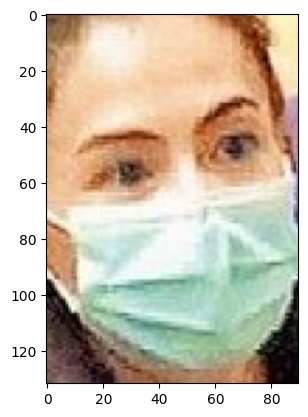

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[500])

In [ ]:
import torchvision.transforms as tt
image_size = (224, 224)

stats = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(**stats)
]))

In [ ]:
val_percentage = 0.1
val_size = int(val_percentage * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [ ]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def denormalize(images, mean, std):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return images * std + mean

def show_first_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], **stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

        # The break is added to only iterate on the first item
        break

show_first_batch(train_dl)

Output hidden; open in https://colab.research.google.com to view.

## Model Training

In [ ]:
EPOCHS = 5

LOSS_FN = nn.BCELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
def train_and_validate(model, optimizer):
    result = []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch}')
        model.train()
        loss_value = 0
        print('Training')
        for batch_idx, (input_data, input_labels) in enumerate(tqdm((train_dl))):
            input_data = input_data.to(device)
            input_labels = input_labels.to(device)

            y_pred = model(input_data)
            y_true = input_labels.view_as(y_pred).float()

            loss = LOSS_FN(y_pred, y_true)
            loss_value += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch_idx % 5 == 0:
                print(f"Batch #{batch_idx}'s loss: {loss.item():.4f}")

        model.eval()

        train_acc = 0
        train_count = 0

        test_acc = 0
        test_count = 0

        print('Testing')
        with torch.no_grad():
            for input_data, input_labels in tqdm(train_dl):
                input_data = input_data.to(device)
                input_labels = input_labels.to(device)
                y_pred = model(input_data)

                train_predictions = (y_pred >= 0.5).float()
                train_correct = train_predictions == input_labels.view_as(train_predictions)
                train_count += len(input_labels)
                train_acc += train_correct.sum().item()

            for input_data, input_labels in tqdm(valid_dl):
                input_data = input_data.to(device)
                input_labels = input_labels.to(device)
                y_pred = model(input_data)

                test_predictions = (y_pred >= 0.5).float()

                test_correct = test_predictions == input_labels.view_as(test_predictions)
                test_count += len(input_labels)
                test_acc += test_correct.sum().item()

        print(f'Epoch {epoch}: train accuracy {(train_acc/train_count*100):.3f}%, loss: {loss_value:.3f} \
                test accuracy {(test_acc/test_count*100):.3f}%')
        result.append({
            'test_accuracy': (test_acc/test_count*100),
            'train_accuracy': (train_acc/train_count*100),
            'loss_value': loss_value,
        })
    return result

def draw_charts(results):
    plt.figure(figsize=(10, 6))
    plt.plot([result['loss_value'] for result in results])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.xticks(range(EPOCHS))
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot([result['train_accuracy'] for result in results], label='Training Accuracy')
    plt.plot([result['test_accuracy'] for result in results], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.xticks(range(EPOCHS))
    plt.show()

## CNN Model (Based on ResNet-34)

In [ ]:
class MasksModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5))
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(3200, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, X):
        z_1 = self.maxpool1(self.relu1(self.conv1(X)))
        z_2 = self.maxpool2(self.relu2(self.conv2(z_1)))
        z_3 = self.maxpool3(self.relu3(self.conv3(z_2)))
        z_4 = self.maxpool4(self.relu4(self.conv4(z_3)))

        z_4 = torch.flatten(z_4, 1)

        fc1_out = self.fc1(z_4)
        fc2_out = self.fc2(fc1_out)
        fc3_out = self.fc3(fc2_out)

        return nn.Sigmoid()(fc3_out)

In [ ]:
%%time
warnings.filterwarnings("ignore")

model1 = MasksModel1()
model1 = model1.to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), 0.001)

result = train_and_validate(model1, optimizer1)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.6979
Batch #5's loss: 0.6162
Batch #10's loss: 0.5502
Batch #15's loss: 0.3950
Batch #20's loss: 0.2834
Batch #25's loss: 0.3549
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 87.835%, loss: 12.382                 test accuracy 88.344%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.3930
Batch #5's loss: 0.1951
Batch #10's loss: 0.2390
Batch #15's loss: 0.2703
Batch #20's loss: 0.3545
Batch #25's loss: 0.2850
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 90.674%, loss: 7.103                 test accuracy 91.126%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2610
Batch #5's loss: 0.2023
Batch #10's loss: 0.2491
Batch #15's loss: 0.1859
Batch #20's loss: 0.2316
Batch #25's loss: 0.1905
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 92.145%, loss: 6.055                 test accuracy 92.583%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2096
Batch #5's loss: 0.1379
Batch #10's loss: 0.1859
Batch #15's loss: 0.1326
Batch #20's loss: 0.1601
Batch #25's loss: 0.1999
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 93.719%, loss: 5.153                 test accuracy 93.642%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2028
Batch #5's loss: 0.1124
Batch #10's loss: 0.1585
Batch #15's loss: 0.1602
Batch #20's loss: 0.1017
Batch #25's loss: 0.1835
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 94.896%, loss: 4.186                 test accuracy 92.980%
CPU times: user 21.4 s, sys: 16.6 s, total: 38.1 s
Wall time: 10min 13s


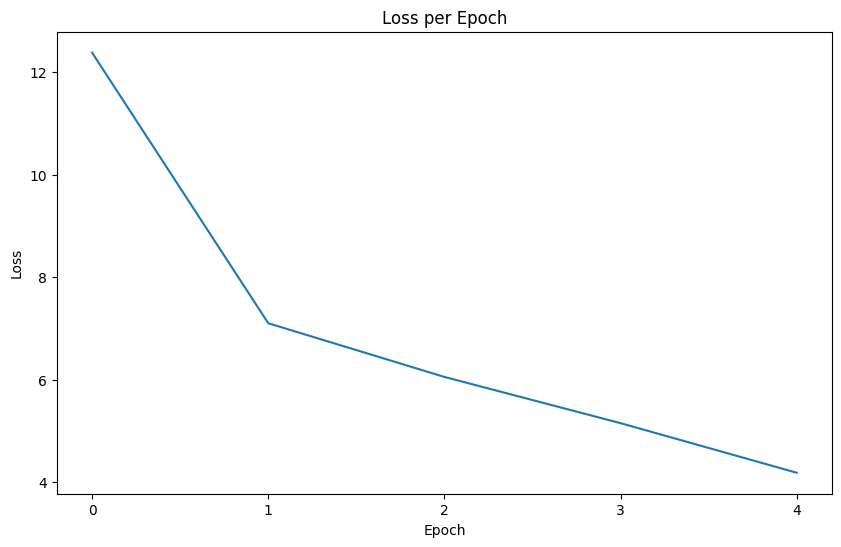

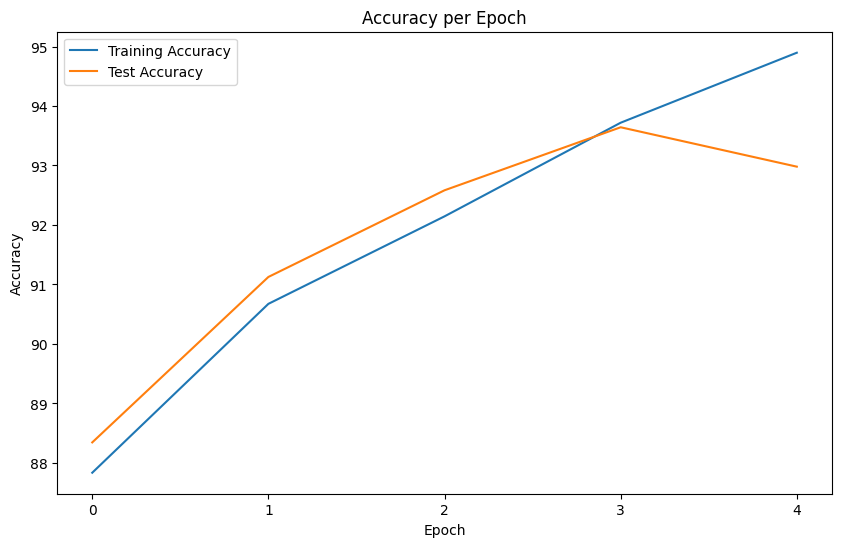

In [ ]:
draw_charts(result)

## Transfer Learning

In [ ]:
from torchvision import models
models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class MasksModelFromResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, train_all_layers=True):
        super().__init__()

        weights = None
        if pretrained:
           weights = models.resnet34().state_dict()

        self.base_model = models.resnet34(weights=weights)

        if not train_all_layers:
            for param in self.base_model.parameters():
                param.requires_grad = False

        self.base_model.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        return nn.Sigmoid()(self.base_model.forward(x))

    def to(self, device):
        new_model = super().to(device)
        new_model.base_model = new_model.base_model.to(device)
        return new_model

### Training from Scratch

In [ ]:
%%time
warnings.filterwarnings("ignore")

model2 = MasksModelFromResNet(len(dataset.classes), pretrained=False, train_all_layers=True)
model2 = model2.to(device)

optimizer2 = torch.optim.Adam(model2.parameters(), 0.0001)

result = train_and_validate(model2, optimizer2)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.7053
Batch #5's loss: 0.5396
Batch #10's loss: 0.4505
Batch #15's loss: 0.3616
Batch #20's loss: 0.3447
Batch #25's loss: 0.2813
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 85.908%, loss: 11.588                 test accuracy 86.093%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2377
Batch #5's loss: 0.2573
Batch #10's loss: 0.2011
Batch #15's loss: 0.1690
Batch #20's loss: 0.2200
Batch #25's loss: 0.1743
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 90.203%, loss: 5.447                 test accuracy 90.066%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.1645
Batch #5's loss: 0.1389
Batch #10's loss: 0.1062
Batch #15's loss: 0.0975
Batch #20's loss: 0.0988
Batch #25's loss: 0.0777
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 98.382%, loss: 2.824                 test accuracy 95.762%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.1152
Batch #5's loss: 0.0293
Batch #10's loss: 0.0306
Batch #15's loss: 0.0265
Batch #20's loss: 0.0392
Batch #25's loss: 0.0535
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 89.982%, loss: 1.051                 test accuracy 86.490%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0179
Batch #5's loss: 0.0191
Batch #10's loss: 0.0411
Batch #15's loss: 0.0133
Batch #20's loss: 0.0161
Batch #25's loss: 0.0175
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 91.277%, loss: 0.869                 test accuracy 88.477%
CPU times: user 1min 3s, sys: 17.6 s, total: 1min 21s
Wall time: 2min 27s


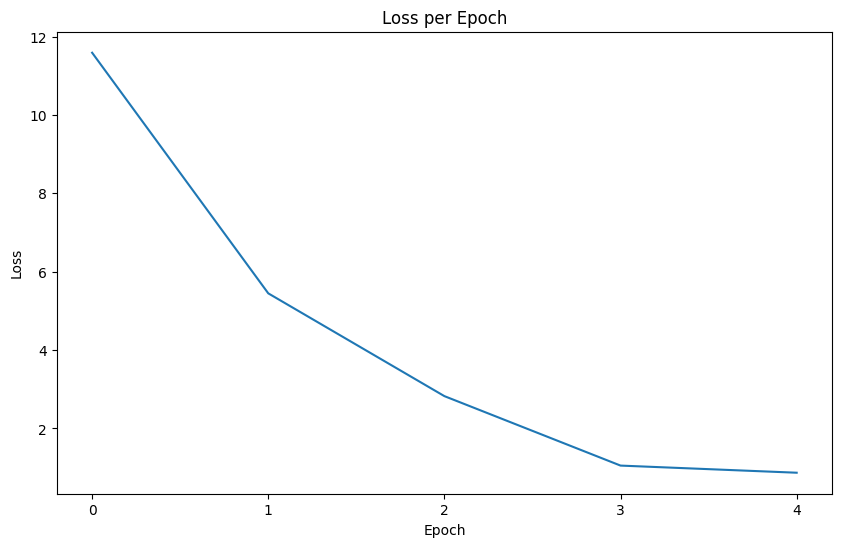

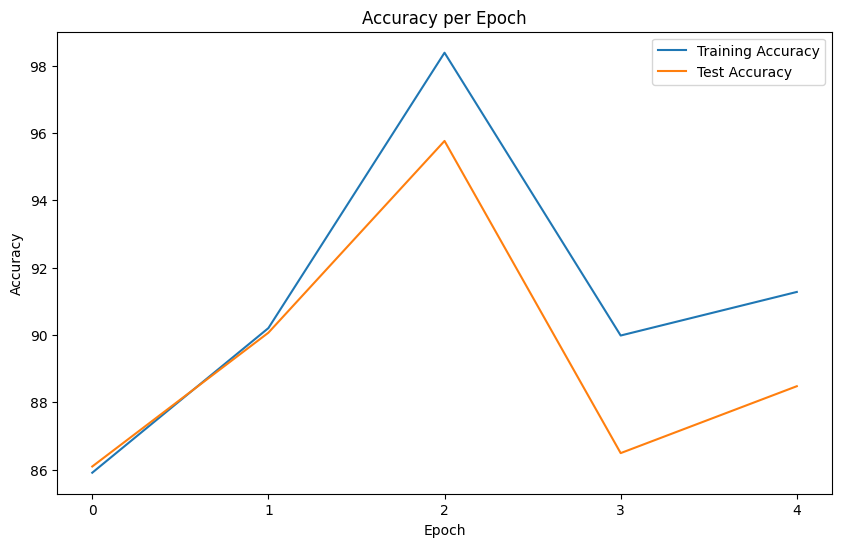

In [ ]:
draw_charts(result)

### Training Freezing Pretrained Layers

In [ ]:
%%time
warnings.filterwarnings("ignore")

model3 = MasksModelFromResNet(len(dataset.classes), pretrained=True, train_all_layers=False)
model3 = model3.to(device)

optimizer3 = torch.optim.Adam(model3.parameters(), 0.0001)

result = train_and_validate(model3, optimizer3)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.7606
Batch #5's loss: 0.7236
Batch #10's loss: 0.6744
Batch #15's loss: 0.6707
Batch #20's loss: 0.6476
Batch #25's loss: 0.6416
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 61.562%, loss: 18.797                 test accuracy 62.119%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.6451
Batch #5's loss: 0.6371
Batch #10's loss: 0.6326
Batch #15's loss: 0.6249
Batch #20's loss: 0.5999
Batch #25's loss: 0.5846
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 72.021%, loss: 16.910                 test accuracy 72.715%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.5910
Batch #5's loss: 0.5951
Batch #10's loss: 0.5854
Batch #15's loss: 0.5809
Batch #20's loss: 0.5751
Batch #25's loss: 0.5746
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 79.700%, loss: 15.628                 test accuracy 81.457%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.5520
Batch #5's loss: 0.5465
Batch #10's loss: 0.5343
Batch #15's loss: 0.5436
Batch #20's loss: 0.5151
Batch #25's loss: 0.5216
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 84.437%, loss: 14.494                 test accuracy 86.358%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.5311
Batch #5's loss: 0.5030
Batch #10's loss: 0.5027
Batch #15's loss: 0.5063
Batch #20's loss: 0.5001
Batch #25's loss: 0.4911
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 87.967%, loss: 13.439                 test accuracy 89.272%
CPU times: user 42.1 s, sys: 17.4 s, total: 59.5 s
Wall time: 2min 19s


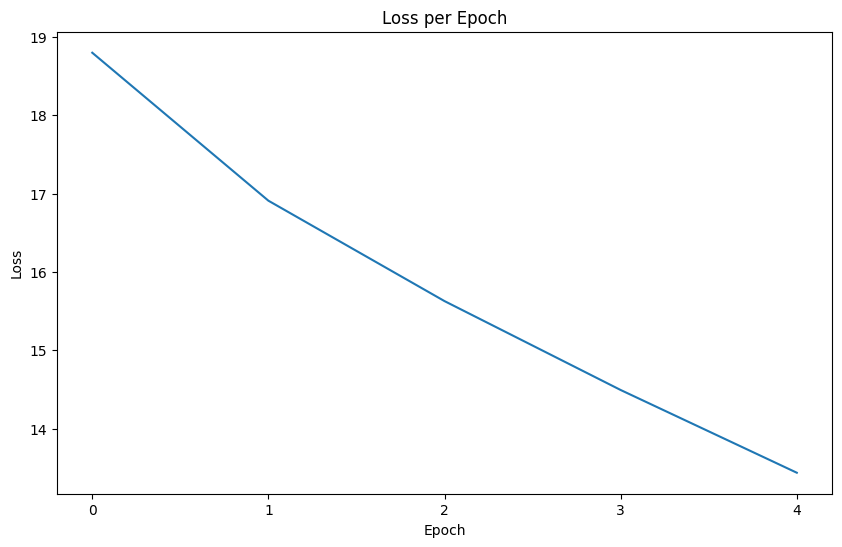

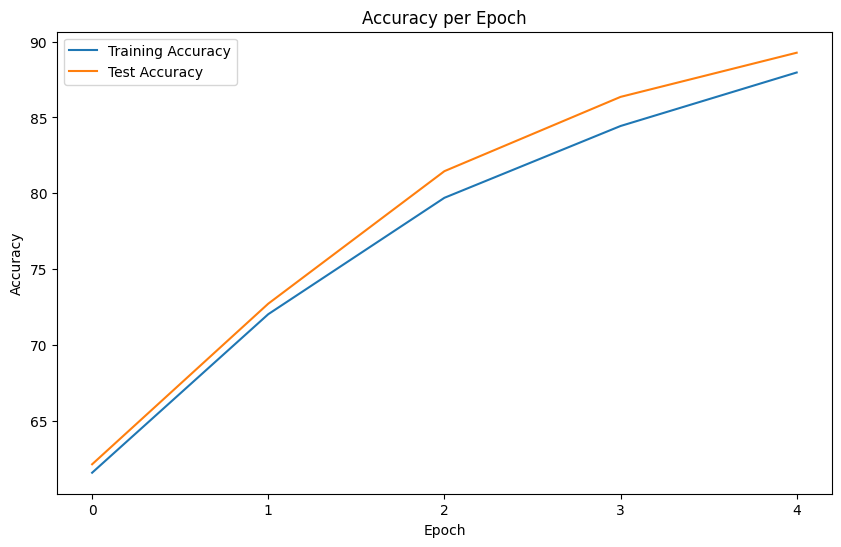

In [ ]:
draw_charts(result)

### Train All Layers from Pretrained Weights

In [ ]:
import os

def train_and_validate_and_save(model, optimizer, checkpoint_dir):

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    result = []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch}')
        model.train()
        loss_value = 0
        print('Training')
        for batch_idx, (input_data, input_labels) in enumerate(tqdm((train_dl))):
            input_data = input_data.to(device)
            input_labels = input_labels.to(device)

            optimizer.zero_grad()
            y_pred = model(input_data)
            y_true = input_labels.view_as(y_pred).float()

            loss = LOSS_FN(y_pred, y_true)
            loss_value += loss.item()

            loss.backward()
            optimizer.step()

            if batch_idx % 5 == 0:
                print(f"Batch #{batch_idx}'s loss: {loss.item():.4f}")

        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_value,
        }, checkpoint_path)

        model.eval()

        train_acc = 0
        train_count = 0

        test_acc = 0
        test_count = 0

        print('Testing')
        with torch.no_grad():
            for input_data, input_labels in tqdm(train_dl):
                input_data = input_data.to(device)
                input_labels = input_labels.to(device)
                y_pred = model(input_data)

                train_predictions = (y_pred >= 0.5).float()
                train_correct = train_predictions == input_labels.view_as(train_predictions)
                train_count += len(input_labels)
                train_acc += train_correct.sum().item()

            for input_data, input_labels in tqdm(valid_dl):
                input_data = input_data.to(device)
                input_labels = input_labels.to(device)
                y_pred = model(input_data)

                test_predictions = (y_pred >= 0.5).float()

                test_correct = test_predictions == input_labels.view_as(test_predictions)
                test_count += len(input_labels)
                test_acc += test_correct.sum().item()

        print(f'Epoch {epoch}: train accuracy {(train_acc/train_count*100):.3f}%, loss: {loss_value:.3f} \
                test accuracy {(test_acc/test_count*100):.3f}%')
        result.append({
            'test_accuracy': (test_acc/test_count*100),
            'train_accuracy': (train_acc/train_count*100),
            'loss_value': loss_value,
        })
    return result

def draw_charts(results):
    plt.figure(figsize=(10, 6))
    plt.plot([result['loss_value'] for result in results])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.xticks(range(EPOCHS))
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot([result['train_accuracy'] for result in results], label='Training Accuracy')
    plt.plot([result['test_accuracy'] for result in results], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.xticks(range(EPOCHS))
    plt.show()


In [ ]:
%%time
warnings.filterwarnings("ignore")

# 체크포인트 디렉토리 생성
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

model4 = MasksModelFromResNet(len(dataset.classes), pretrained=True, train_all_layers=True)
model4 = model4.to(device)

optimizer4 = torch.optim.Adam(model4.parameters(), 0.0001)

result = train_and_validate_and_save(model4, optimizer4, checkpoint_dir)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.8399
Batch #5's loss: 0.0638
Batch #10's loss: 0.0325
Batch #15's loss: 0.0038
Batch #20's loss: 0.0194
Batch #25's loss: 0.0036
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 99.926%, loss: 2.239                 test accuracy 99.868%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0050
Batch #5's loss: 0.0013
Batch #10's loss: 0.0008
Batch #15's loss: 0.0009
Batch #20's loss: 0.0009
Batch #25's loss: 0.0009
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 100.000%, loss: 0.078                 test accuracy 99.868%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0011
Batch #5's loss: 0.0017
Batch #10's loss: 0.0005
Batch #15's loss: 0.0006
Batch #20's loss: 0.0004
Batch #25's loss: 0.0006
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 100.000%, loss: 0.024                 test accuracy 99.868%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0003
Batch #5's loss: 0.0007
Batch #10's loss: 0.0009
Batch #15's loss: 0.0004
Batch #20's loss: 0.0003
Batch #25's loss: 0.0006
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 100.000%, loss: 0.013                 test accuracy 99.868%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0003
Batch #5's loss: 0.0003
Batch #10's loss: 0.0003
Batch #15's loss: 0.0003
Batch #20's loss: 0.0005
Batch #25's loss: 0.0003
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 100.000%, loss: 0.009                 test accuracy 99.868%
CPU times: user 1min 4s, sys: 17.8 s, total: 1min 22s
Wall time: 2min 27s


In [ ]:
for r in result:
    print(r['test_accuracy'])

99.86754966887416
99.86754966887416
99.86754966887416
99.86754966887416
99.86754966887416


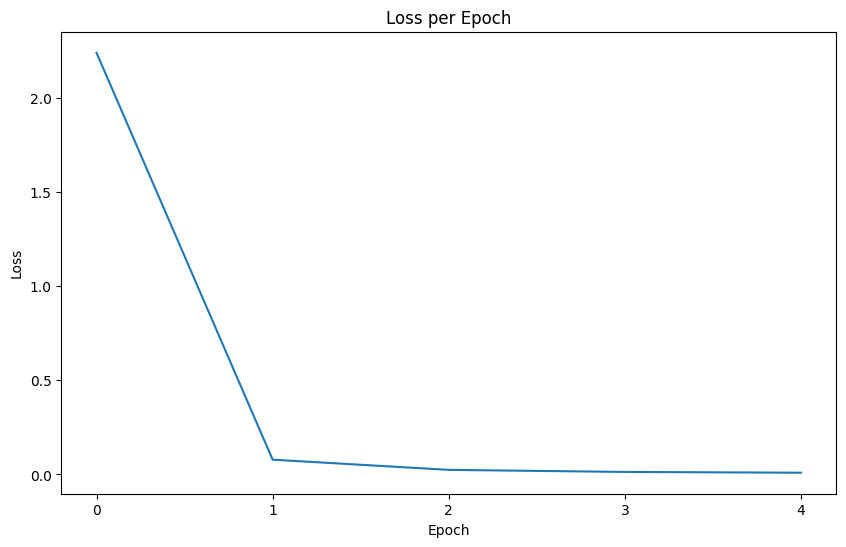

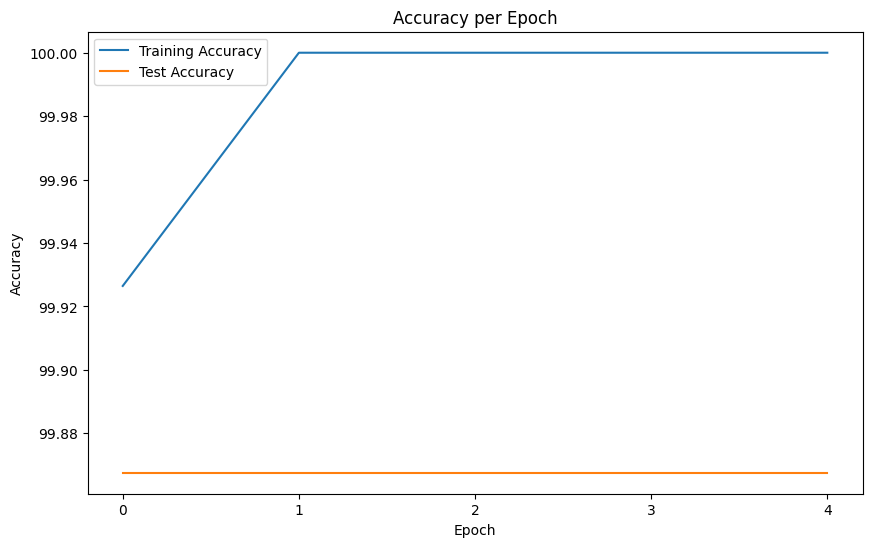

In [ ]:
draw_charts(result)

## Inference

0


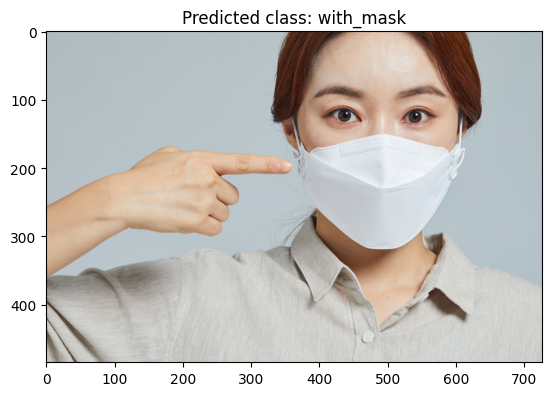

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# 모델과 체크포인트 경로 설정
model_path = './checkpoints/checkpoint_epoch_2.pth'
image_path = './data/test/test_mask.jpg'

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 모델 구조 정의 및 체크포인트 로드
model4 = MasksModelFromResNet(len(dataset.classes), pretrained=True, train_all_layers=True)
model4.load_state_dict(torch.load(model_path)['model_state_dict'])

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4.to(device)
model4.eval()

# 이미지 로드 및 전처리
image = Image.open(image_path)
transformed_image = transform(image).unsqueeze(0).to(device)

# Inference 수행
with torch.no_grad():
    output = model4(transformed_image)
    prediction = int(output >= 0.5)

# 결과 출력
class_names = ['with_mask', 'without_mask']  # 클래스 이름 설정
print(prediction)
plt.title(f'Predicted class: {class_names[prediction]}')
plt.imshow(image)
plt.show()